## Importing the libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [2]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# 3. Movie Genre Classification using FeedFroward NNs

1. Download the dataset of HW4 (Click Here!), which consists of three files: train.txt, validation.txt and test.txt. Each line of a file contains a movie name, movie genre and a short description of the movie. The task is to classify movie genre using the given description. Read the dataset and report the data statistics (number of classes, number of instances in each class) for train, validation and test sets.

### 3.a Data Statistics

In [4]:
train_df = pd.read_csv('hw04_data/train.csv')
test_df = pd.read_csv('hw04_data/test.csv')
validation_df = pd.read_csv('hw04_data/validation.csv')

In [6]:
def get_DatasetDistribution(dataframe, name):
    print(dataframe.genre.value_counts())
    dataframe['genre'].value_counts().plot(kind='bar')
    plt.title(f"{name} dataset distribution")
    plt.show()

TRAINING DATA.................................................
drama          5483
documentary    4861
comedy         3896
horror         2104
thriller       1568
action         1312
Name: genre, dtype: int64


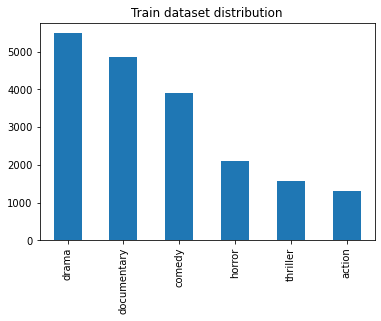

.................................................
TESTING DATA.................................................
drama          3012
documentary    2716
comedy         2241
horror         1102
thriller        795
action          657
Name: genre, dtype: int64


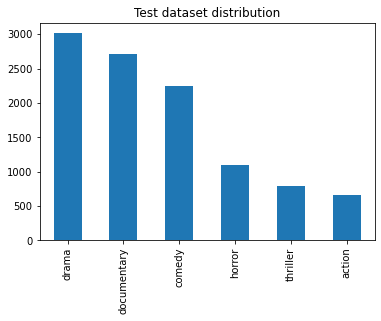

.................................................
VALIDATION DATA.................................................
drama          3012
documentary    2716
comedy         2241
horror         1102
thriller        795
action          657
Name: genre, dtype: int64


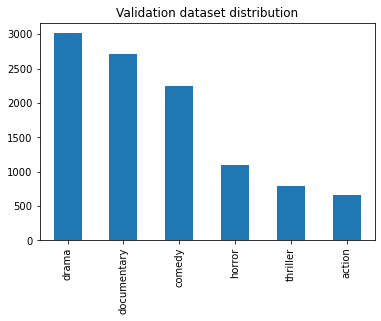

.................................................


In [7]:
print("TRAINING DATA.................................................")
get_DatasetDistribution(train_df,"Train")
print(".................................................")
print("TESTING DATA.................................................")
get_DatasetDistribution(test_df,"Test")
print(".................................................")
print("VALIDATION DATA.................................................")
get_DatasetDistribution(validation_df,"Validation")
print(".................................................")

### 3.b Feed Forward Neural Network Implementation

2. Implement a Feed Forward Neural Network with n layers using PyTorch that takes as input the number of layers n and the number of nodes in each layer, Sl for l ∈ {1,...,n}. The loss function must be the cross-entropy loss. Use an activation function of your choice and also choose optimizer, learning rate, batch size, and epoch.

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(train_df.genre)

trainX = torch.tensor(train_df[train_df.columns[:-1]].values)
trainY = torch.tensor(label_encoder.transform(train_df['genre']))

testX = torch.tensor(test_df[test_df.columns[:-1]].values)
testY = torch.tensor(label_encoder.transform(test_df.genre.values))

validationX = torch.tensor(validation_df[validation_df.columns[:-1]].values)
validationY = torch.tensor(label_encoder.transform(validation_df.genre.values))

In [9]:
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(testX, testY)
test_dataset = TensorDataset(validationX, validationY)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [20]:
def makeNN(layers, nodes, activation_function, learning_rate, epochs, train_dataloader, val_dataloader):
    labels = train_dataloader.dataset.tensors[1].unique().shape[0]
    
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.ModuleList()
            for i in range(layers):
                if i==0:
                    self.layers.append(nn.Linear(train_dataloader.dataset.tensors[0].shape[1] ,nodes[i], dtype=torch.float64))
                else:
                    self.layers.append(nn.Linear(nodes[i-1], nodes[i], dtype=torch.float64))
            self.layers.append(nn.Linear(nodes[i-1], labels, dtype=torch.float64))
        
        def forward(self, X):
            x = X
            for layer in self.layers[:-1]:
                x = activation_function(layer(x))
            x = self.layers[-1](x)

            return x
        
    criterion = nn.CrossEntropyLoss()
    model = NeuralNetwork()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model.layers)
    
    train_losses = []
    val_losses = []
    best_val_loss = 99999999.0
    best_model = None
    
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        model.train()
        for i, (data, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_losses.append(running_train_loss / len(train_dataloader))
        model.eval()
        with torch.no_grad():
            for i, (data, labels) in enumerate(val_dataloader):
                outputs = model(data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
            val_losses.append(running_val_loss / len(val_dataloader))
        print(f"--- epoch #{epoch+1}: \n  || train_loss: {train_losses[-1]:.4f} || validation_loss: {val_losses[-1]:.4f}||")
        
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = copy.deepcopy(model)
        
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return best_model

In [21]:
def evaluateNN(model, test_dataloader, name, return_arg = False):
    model.eval()
    with torch.no_grad():
        # for data, labels in test_loader
        outputs = model(test_dataloader.dataset.tensors[0])
        labels = test_dataloader.dataset.tensors[1]
        _, predicted = torch.max(outputs.data, 1)

        cm = metrics.confusion_matrix(predicted,labels)
        accuracies_in_class = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal()
        if return_arg:
            return np.round(metrics.accuracy_score(predicted,labels),3), accuracies_in_class
        else:
            print("\nCategorical Mean Accuracy:", np.round(metrics.accuracy_score(predicted,labels),3))
            print("\n...........................\n")
            for i in range(len(accuracies_in_class)):
                print("Class Accuracy "+ label_encoder.inverse_transform([i])[0] + " : "+ str(np.round(accuracies_in_class[i],3)))
            print("\n")
            print(metrics.classification_report(predicted, labels))        

In [22]:
activation = nn.Tanh()

### 3.c Model 1

3. Train the NN with one hidden layer having 64 neurons on the training dataset. Use the val- idation dataset during training to select the best performing model. Evaluate the best model on the test dataset. Report the mean classification accuracy and mean per class accuracy for train set, validation set and test set. Also, plot training and validation losses with respect to epoch in the same figure.

ModuleList(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=6, bias=True)
)
--- epoch #1: 
  || train_loss: 1.5701 || validation_loss: 1.4468||
--- epoch #2: 
  || train_loss: 1.2988 || validation_loss: 1.2347||
--- epoch #3: 
  || train_loss: 1.1686 || validation_loss: 1.1541||
--- epoch #4: 
  || train_loss: 1.0944 || validation_loss: 1.1098||
--- epoch #5: 
  || train_loss: 1.0627 || validation_loss: 1.0726||
--- epoch #6: 
  || train_loss: 1.0278 || validation_loss: 1.0385||
--- epoch #7: 
  || train_loss: 1.0251 || validation_loss: 1.1235||
--- epoch #8: 
  || train_loss: 1.0112 || validation_loss: 1.1453||
--- epoch #9: 
  || train_loss: 0.9911 || validation_loss: 1.0262||
--- epoch #10: 
  || train_loss: 0.9761 || validation_loss: 1.0678||


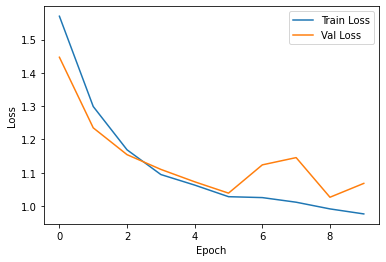

In [23]:
model1 = makeNN(layers=1, nodes=[64], activation_function=activation, 
                                  learning_rate=0.001, epochs=10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [24]:
evaluateNN(model1, train_dataloader, "Training Metrics")
evaluateNN(model1, test_dataloader, "Testing Metrics")
evaluateNN(model1, val_dataloader, "Validation Metrics")


Categorical Mean Accuracy: 0.618

...........................

Class Accuracy action : 0.702
Class Accuracy comedy : 0.695
Class Accuracy documentary : 0.832
Class Accuracy drama : 0.478
Class Accuracy horror : 0.705
Class Accuracy thriller : 0.482


              precision    recall  f1-score   support

           0       0.27      0.70      0.39       497
           1       0.49      0.69      0.57      2725
           2       0.77      0.83      0.80      4492
           3       0.84      0.48      0.61      9590
           4       0.58      0.70      0.64      1727
           5       0.06      0.48      0.11       193

    accuracy                           0.62     19224
   macro avg       0.50      0.65      0.52     19224
weighted avg       0.72      0.62      0.64     19224


Categorical Mean Accuracy: 0.61

...........................

Class Accuracy action : 0.683
Class Accuracy comedy : 0.681
Class Accuracy documentary : 0.814
Class Accuracy drama : 0.476
Class Accuracy hor

### 3.d Model 2

4. Train the NN with two hidden layers having 64 neurons each on the training dataset. Use the validation dataset during training to select the best performing model. Evaluate the best model on the test dataset. Report the mean classification accuracy and mean per class accu- racy for train set, validation set and test set. Also, plot training and validation losses with respect to epoch in the same figure.

ModuleList(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=6, bias=True)
)
--- epoch #1: 
  || train_loss: 1.5766 || validation_loss: 1.3602||
--- epoch #2: 
  || train_loss: 1.2730 || validation_loss: 1.2170||
--- epoch #3: 
  || train_loss: 1.1249 || validation_loss: 1.1053||
--- epoch #4: 
  || train_loss: 1.0783 || validation_loss: 1.0742||
--- epoch #5: 
  || train_loss: 1.0348 || validation_loss: 1.1259||
--- epoch #6: 
  || train_loss: 1.0007 || validation_loss: 1.0504||
--- epoch #7: 
  || train_loss: 1.0049 || validation_loss: 1.0936||
--- epoch #8: 
  || train_loss: 0.9766 || validation_loss: 0.9875||
--- epoch #9: 
  || train_loss: 0.9772 || validation_loss: 0.9861||
--- epoch #10: 
  || train_loss: 0.9496 || validation_loss: 1.1328||


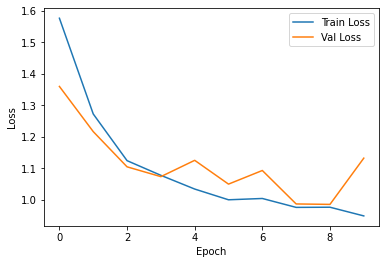

In [25]:
model2 = makeNN(layers=2,nodes=[64,64], activation_function=activation,
                                  learning_rate=0.001,epochs=10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [26]:
evaluateNN(model2, train_dataloader, "Training Metrics")
evaluateNN(model2, test_dataloader, "Testing Metrics")
evaluateNN(model2, val_dataloader, "Validation Metrics")


Categorical Mean Accuracy: 0.647

...........................

Class Accuracy action : 0.677
Class Accuracy comedy : 0.715
Class Accuracy documentary : 0.774
Class Accuracy drama : 0.539
Class Accuracy horror : 0.711
Class Accuracy thriller : 0.403


              precision    recall  f1-score   support

           0       0.38      0.68      0.48       730
           1       0.49      0.71      0.58      2673
           2       0.86      0.77      0.81      5383
           3       0.76      0.54      0.63      7756
           4       0.67      0.71      0.69      1988
           5       0.18      0.40      0.25       694

    accuracy                           0.65     19224
   macro avg       0.56      0.64      0.57     19224
weighted avg       0.71      0.65      0.66     19224


Categorical Mean Accuracy: 0.63

...........................

Class Accuracy action : 0.593
Class Accuracy comedy : 0.699
Class Accuracy documentary : 0.76
Class Accuracy drama : 0.53
Class Accuracy horro

### 3.e Model 3

5. Repeat (c) using 128 neurons for the hidden layer.

ModuleList(
  (0): Linear(in_features=300, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=6, bias=True)
)
--- epoch #1: 
  || train_loss: 1.5442 || validation_loss: 1.3657||
--- epoch #2: 
  || train_loss: 1.2840 || validation_loss: 1.2036||
--- epoch #3: 
  || train_loss: 1.1472 || validation_loss: 1.2144||
--- epoch #4: 
  || train_loss: 1.1020 || validation_loss: 1.1257||
--- epoch #5: 
  || train_loss: 1.0506 || validation_loss: 1.0466||
--- epoch #6: 
  || train_loss: 1.0320 || validation_loss: 1.0319||
--- epoch #7: 
  || train_loss: 1.0112 || validation_loss: 1.0790||
--- epoch #8: 
  || train_loss: 1.0114 || validation_loss: 1.1259||
--- epoch #9: 
  || train_loss: 0.9888 || validation_loss: 1.1201||
--- epoch #10: 
  || train_loss: 0.9839 || validation_loss: 1.0694||


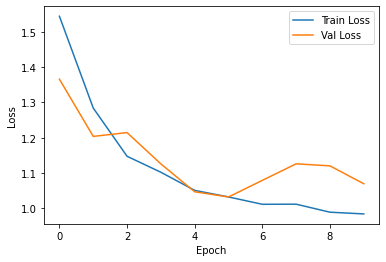

In [27]:
model3 = makeNN(layers=1, nodes=[128], activation_function=activation, 
                                  learning_rate=0.001, epochs=10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [28]:
evaluateNN(model3, train_dataloader, "Training Metrics")
evaluateNN(model3, test_dataloader, "Testing Metrics")
evaluateNN(model3, val_dataloader, "Validation Metrics")


Categorical Mean Accuracy: 0.622

...........................

Class Accuracy action : 0.728
Class Accuracy comedy : 0.639
Class Accuracy documentary : 0.762
Class Accuracy drama : 0.507
Class Accuracy horror : 0.732
Class Accuracy thriller : 0.428


              precision    recall  f1-score   support

           0       0.23      0.73      0.35       412
           1       0.54      0.64      0.59      3300
           2       0.85      0.76      0.80      5440
           3       0.76      0.51      0.61      8208
           4       0.50      0.73      0.60      1450
           5       0.11      0.43      0.18       414

    accuracy                           0.62     19224
   macro avg       0.50      0.63      0.52     19224
weighted avg       0.70      0.62      0.64     19224


Categorical Mean Accuracy: 0.617

...........................

Class Accuracy action : 0.748
Class Accuracy comedy : 0.634
Class Accuracy documentary : 0.741
Class Accuracy drama : 0.504
Class Accuracy ho

### 3.f Model 4

6. Repeat (d) using 128 neurons for both the hidden layers.  

ModuleList(
  (0): Linear(in_features=300, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=6, bias=True)
)
--- epoch #1: 
  || train_loss: 1.4799 || validation_loss: 1.2787||
--- epoch #2: 
  || train_loss: 1.2035 || validation_loss: 1.2434||
--- epoch #3: 
  || train_loss: 1.1089 || validation_loss: 1.1844||
--- epoch #4: 
  || train_loss: 1.0640 || validation_loss: 1.1739||
--- epoch #5: 
  || train_loss: 1.0427 || validation_loss: 1.0452||
--- epoch #6: 
  || train_loss: 1.0276 || validation_loss: 1.1148||
--- epoch #7: 
  || train_loss: 0.9986 || validation_loss: 1.0220||
--- epoch #8: 
  || train_loss: 1.0107 || validation_loss: 1.0682||
--- epoch #9: 
  || train_loss: 1.0008 || validation_loss: 1.2398||
--- epoch #10: 
  || train_loss: 0.9687 || validation_loss: 1.0124||


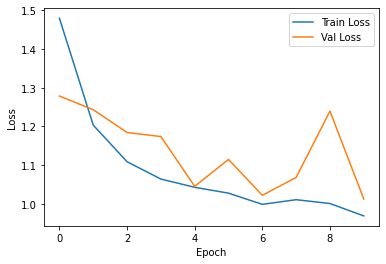

In [29]:
model4 = makeNN(2,[128,128], activation,0.001,10, train_dataloader, val_dataloader)

In [31]:
evaluateNN(model4, train_dataloader, "Training Metrics")
evaluateNN(model4, test_dataloader, "Testing Metrics")
evaluateNN(model4, val_dataloader, "Validation Metrics")


Categorical Mean Accuracy: 0.652

...........................

Class Accuracy action : 0.566
Class Accuracy comedy : 0.756
Class Accuracy documentary : 0.751
Class Accuracy drama : 0.557
Class Accuracy horror : 0.685
Class Accuracy thriller : 0.5


              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1377
           1       0.43      0.76      0.55      2200
           2       0.87      0.75      0.81      5660
           3       0.74      0.56      0.64      7274
           4       0.75      0.68      0.71      2295
           5       0.13      0.50      0.21       418

    accuracy                           0.65     19224
   macro avg       0.59      0.64      0.58     19224
weighted avg       0.72      0.65      0.67     19224


Categorical Mean Accuracy: 0.624

...........................

Class Accuracy action : 0.462
Class Accuracy comedy : 0.732
Class Accuracy documentary : 0.733
Class Accuracy drama : 0.547
Class Accuracy horr

### 3.g Model Comparison

7. Compare the results and explain the effects of the number of hidden layers and number of neurons.

In [33]:
value_map = {"model 1": "One hidden layer with 64 neurons",
            "model 2" : "Two hidden layers with 64 neurons",
            "model 3" : "One hidden layer with 128 neurons",
            "model 4" : "Two hidden layer with 128 neurons"}

model1_acc, model1_byclass = evaluateNN(model1, test_dataloader, "Testing Metrics", True)
model2_acc, model2_byclass = evaluateNN(model2, test_dataloader, "Testing Metrics", True)
model3_acc, model3_byclass = evaluateNN(model3, test_dataloader, "Testing Metrics", True)
model4_acc, model4_bylass = evaluateNN(model4, test_dataloader, "Testing Metrics", True)

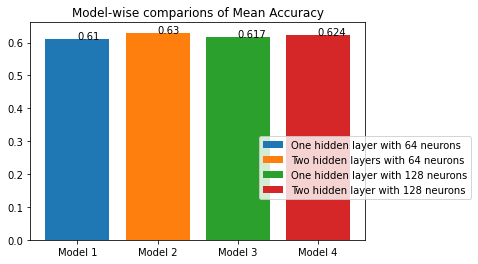

In [34]:
plt.bar("Model 1" ,model1_acc, label = value_map['model 1'])
plt.text("Model 1", model1_acc , str(model1_acc))

plt.bar('Model 2', model2_acc, label = value_map['model 2'])
plt.text("Model 2", model2_acc , str(model2_acc))

plt.bar('Model 3', model3_acc, label = value_map['model 3'])
plt.text("Model 3", model3_acc , str(model3_acc))

plt.bar('Model 4', model4_acc, label = value_map['model 4'])
plt.text("Model 4", model4_acc , str(model4_acc))

plt.title("Model-wise comparions of Mean Accuracy")
plt.legend(loc="upper center",bbox_to_anchor =(1,0.5))
plt.show()

**The mean accuracy is highest when the model is trained with 64 neurons and 2 hidden layers with a mean accuracy of 0.63**

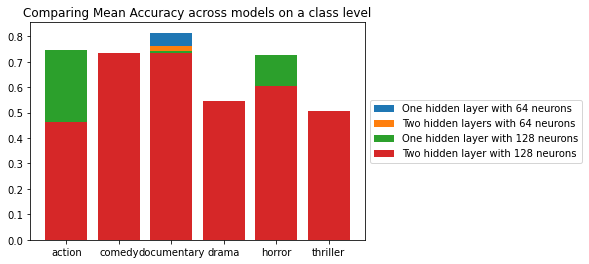

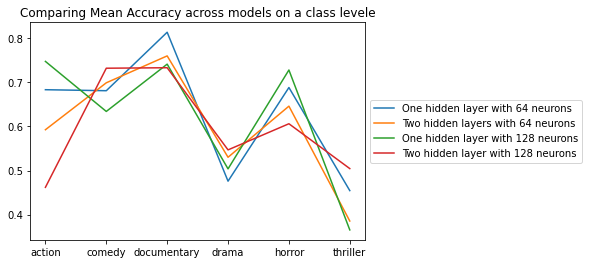

In [35]:
x = label_encoder.classes_

plt.bar(x,model1_byclass, label = value_map['model 1'])
plt.bar(x,model2_byclass, label = value_map['model 2'])
plt.bar(x,model3_byclass, label = value_map['model 3'])
plt.bar(x,model4_bylass, label = value_map['model 4'])
plt.title("Comparing Mean Accuracy across models on a class level")
plt.legend(loc="center left",bbox_to_anchor =(1,0.5))
plt.show()

plt.plot(x,model1_byclass, label = value_map['model 1'])
plt.plot(x,model2_byclass, label = value_map['model 2'])
plt.plot(x,model3_byclass, label = value_map['model 3'])
plt.plot(x,model4_bylass, label = value_map['model 4'])
plt.title("Comparing Mean Accuracy across models on a class levele")
plt.legend(loc="center left",bbox_to_anchor =(1,0.5))
plt.show()

**INFERENCE**

It can be seen from the comparison of perfromance that the 128 Neuron - 1 Hidden Layer is better and balanced across all classes than the the 128 Neuron - 2 Hidden Layers across the majority of labels

However there are some exceptions across certain classes as seen in the line and bar graph

Thus we can generalize that there is a certain balance between the number of neurons and hidden layers.

The more number of neurons can increase the complexity of the model and hurt its balanced performance. However, increasing the number of hidden layers improves the balanced performance across classes, and less hidden layers leads to unpredictable performances.


# 4. Image Recognition using Convolutional Neural Nets (CNNs)

Image Recognition using Convolutional Neural Nets (CNNs). In this exercise, you will implement a CNN using PyTorch to classify CIFAR10 images from 10 classes.

1) DownloadCIFAR10datasetfromhttps://www.cs.toronto.edu/ ̃kriz/cifar. html. There are 5 files for training sets and 1 file for test set. Use the first four training files for training, the 5-th training file for validation, and the test file for testing. The task is to classify a given image into one of 10 classes. Read the webpage/dataset and report the data statistics (number of instances in each class) for train, validation and test sets. The data for each image has three channels (R,G,B) and each pixel value is between 0 and 255. Normalize the images so that the maximum and minimum pixel values are between -1 and +1.

## 4.1 Data Prep

In [36]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [39]:
train_1 = unpickle('cifar-10-batches-py/data_batch_1')
train_2 = unpickle('cifar-10-batches-py/data_batch_2')
train_3 = unpickle('cifar-10-batches-py/data_batch_3')
train_4 = unpickle('cifar-10-batches-py/data_batch_4')
val_dict = unpickle('cifar-10-batches-py/data_batch_5')
test_dict = unpickle('cifar-10-batches-py/test_batch')

In [40]:
train_dict = {}
train_dict[b'data'] = np.concatenate((train_1[b'data'], train_2[b'data'], 
                                      train_3[b'data'], train_4[b'data']), axis=0).reshape(-1,3,32,32)
train_dict[b'labels'] = ([*train_1[b'labels'], *train_2[b'labels'], 
    *train_3[b'labels'], *train_4[b'labels']])
train_dict[b'filenames'] = ([*train_1[b'filenames'], *train_2[b'filenames'], 
    *train_3[b'filenames'], *train_4[b'filenames']])

In [41]:
import torchvision.transforms as transforms

def normalize(images):
    transform_normalize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    transformImg = []
    for image in images:
        transformImg.append(transform_normalize(image.reshape(32,32,3)).reshape(-1,3,32,32))
        
    result = torch.cat(transformImg, dim=0) 
    return result
    

In [42]:
train_dict[b'data'] = normalize(train_dict[b'data'])
test_dict[b'data'] = normalize(test_dict[b'data'])
val_dict[b'data'] = normalize(val_dict[b'data'])

## CNN Implementation

2. Implement a CNN as follows: the first convolutional layer, gets a 3x32x32 image and applies 6 filters/kernels of size 5x5, followed by applying ReLu activation and then max-pooling with a window of size 2x2. The second convolution layer receives the input from the first layer and applies 16 filters/kernels of size 5x5, followed by applying ReLu activation and then max-pooling with a window of size 2x2. The results are then given to a feedforward NN, with three layers with 120 (with ReLu), 84 (with ReLu), 10 (you can use either softmax or no activation function) neurons. The loss function must be the cross-entropy loss. Use SGD optimizer, learning rate of 0.01 and momentum of 0.9. You need to choose the batch size, and the number of epochs.

In [43]:
trainX = train_dict[b'data']
trainY = torch.tensor(train_dict[b'labels'])

testX = test_dict[b'data']
testY = torch.tensor(test_dict[b'labels'])

validationX = val_dict[b'data']
validationY = torch.tensor(val_dict[b'labels'])

In [46]:
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(testX, testY)
test_dataset = TensorDataset(validationX, validationY)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)
test_dataloader = DataLoader(test_dataset, batch_size=256)

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool_layer = nn.MaxPool2d(kernel_size=2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool_layer(x)
        x = self.activation(self.conv2(x))
        x = self.pool_layer(x)
        x = x.view(-1, 16*5*5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
--- epoch #1: 
  || train_loss: 2.2011 || validation_loss: 2.0092||
--- epoch #2: 
  || train_loss: 1.9224 || validation_loss: 1.8093||
--- epoch #3: 
  || train_loss: 1.7554 || validation_loss: 1.6869||
--- epoch #4: 
  || train_loss: 1.6503 || validation_loss: 1.6237||
--- epoch #5: 
  || train_loss: 1.5731 || validation_loss: 1.5427||
--- epoch #6: 
  || train_loss: 1.4952 || validation_loss: 1.4771||
--- epoch #7: 
  || train_loss: 1.4336 || validation_loss: 1.4272||
--- epoch #8: 
  || train_loss: 1.3937 || validation_loss: 1.3949||
--- epoch #9: 
  || train_loss: 1

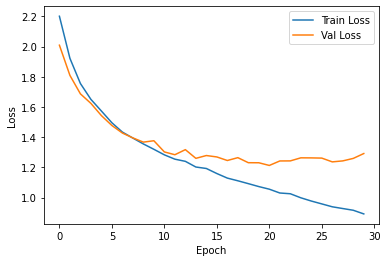

In [49]:
criterion = nn.CrossEntropyLoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)

epochs = 30
train_losses = []
val_losses = []
best_val_loss = 99999999.0
best_model = None

for epoch in range(epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0
    model.train()
    for i, (data, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_dataloader))
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(val_dataloader):
            outputs = model(data)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_dataloader))
    print(f"--- epoch #{epoch+1}: \n  || train_loss: {train_losses[-1]:.4f} || validation_loss: {val_losses[-1]:.4f}||")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model = copy.deepcopy(model)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [52]:
def eval_cnn(model, test_loader, name, return_arg = False):
    model.eval()
    with torch.no_grad():
        # for data, labels in test_loader
        outputs = model(test_loader.dataset.tensors[0])
        labels = test_loader.dataset.tensors[1]
        _, predicted = torch.max(outputs.data, 1)

        cm = metrics.confusion_matrix(predicted,labels)
        accuracies_in_class = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal()
        if return_arg:
            return np.round(metrics.accuracy_score(predicted,labels),3), accuracies_in_class
        else:
            print("---------------------"+ color.BOLD + name + color.END+"---------------------")
            print("\nMean Accuracy Score across all categories:", np.round(metrics.accuracy_score(predicted,labels),3))
            print("\n")
            for i in range(len(accuracies_in_class)):
                print("Accuracy for class "+ str(i) + " : "+ color.BOLD + str(np.round(accuracies_in_class[i],3)) + color.END)
            print("\n")
eval_cnn(best_model, test_dataloader, "Test")

---------------------Test---------------------

Mean Accuracy Score across all categories: 0.569


Accuracy for class 0 : 0.577
Accuracy for class 1 : 0.658
Accuracy for class 2 : 0.548
Accuracy for class 3 : 0.394
Accuracy for class 4 : 0.507
Accuracy for class 5 : 0.507
Accuracy for class 6 : 0.625
Accuracy for class 7 : 0.593
Accuracy for class 8 : 0.722
Accuracy for class 9 : 0.567


